### Importing and mapping netCDF data with xarray and cartopy

- Read data from a netCDF file with xarray
- Select (index) and modify variables using xarray
- Set up map features with cartopy (lat/lon tickmarks, continents, country/state borders, etc.)
- Overlay various plot types: contour lines, filled contours, vectors, and barbs
- Customize plot elements such as the colorbar and titles
- Save figure
    

In [1]:
## Imports

import os, sys
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


### Load netcdf data with Xarray

In this example, we show how to import and map ERA5 reanalysis data for an AR-Thunderstorm event that occurred in Santa Barbara County on 6 March 2019. We will use the `era5.AR-LTG.6hr.nc` sample data file, which contains 6-hourly ERA5 Reanalysis on a 0.5 x 0.5 deg lat-lon grid during 4-8 March (5 days). ERA5 data was retrieved from the Climate Data Store and subset to a regional domain over the Western US/N. Pacific. 

The xarray package provides an easy interface for importing and analyzing multidimensional data. Because xarray was designed around the netCDF data model, it is an especially useful tool for working with weather and climate data.


Xarray has two fundamental **data structures**:  

**1.** a **`DataArray`**, which holds a single n-dimensional variable. Elements of a DataArray include:
   - `values`: numpy array of data values
   - `dims`: list of named dimensions (for example, `['time','lat','lon']`)
   - `coords`: coordinate arrays (e.g., vectors of lat/lon values or datetime data)
   - `atts`: variable attributes such as `units` and `standard_name`   
    
**2.** a **`Dataset`**, which holds multiple n-dimensional variables (shared coordinates). Elements of a Dataset: data variables, dimensions, coordinates, and attributes.


In the cell below, we will load the ERA5 data (netcdf file) into an xarray dataset.


In [3]:
# Path to ERA5 data
filepath = "../sample-data/era5.6hr.AR-thunderstorm.20190304_08.nc"

# Read nc file into xarray dataset
ds = xr.open_dataset(filepath)

# Print dataset contents 
print(ds)


<xarray.Dataset>
Dimensions:    (latitude: 61, level: 3, longitude: 91, time: 20)
Coordinates:
  * longitude  (longitude) float32 -145.0 -144.5 -144.0 ... -101.0 -100.5 -100.0
  * latitude   (latitude) float32 52.0 51.5 51.0 50.5 ... 23.5 23.0 22.5 22.0
  * level      (level) float64 250.0 500.0 850.0
  * time       (time) datetime64[ns] 2019-03-04 ... 2019-03-08T18:00:00
Data variables:
    zg         (time, level, latitude, longitude) float64 ...
    u          (time, level, latitude, longitude) float64 ...
    v          (time, level, latitude, longitude) float64 ...
    msl        (time, latitude, longitude) float64 ...
    prec       (time, latitude, longitude) float64 ...
Attributes:
    CDI:                       Climate Data Interface version 1.8.2 (http://m...
    Conventions:               CF-1.6
    NCO:                       4.6.7
    nco_openmp_thread_number:  1
    CDO:                       Climate Data Operators version 1.8.2 (http://m...
    title:                     

### Selecting/Indexing data with xarray

We can always use regular numpy indexing and slicing on DataArrays and Datasets; however, 
it is often more powerful and easier to use xarray’s `.sel()` method of label-based indexing.


In [4]:
# Select a single day 
ds.sel(time='2019-03-06')


<xarray.Dataset>
Dimensions:    (latitude: 61, level: 3, longitude: 91, time: 4)
Coordinates:
  * longitude  (longitude) float32 -145.0 -144.5 -144.0 ... -101.0 -100.5 -100.0
  * latitude   (latitude) float32 52.0 51.5 51.0 50.5 ... 23.5 23.0 22.5 22.0
  * level      (level) float64 250.0 500.0 850.0
  * time       (time) datetime64[ns] 2019-03-06 ... 2019-03-06T18:00:00
Data variables:
    zg         (time, level, latitude, longitude) float64 ...
    u          (time, level, latitude, longitude) float64 ...
    v          (time, level, latitude, longitude) float64 ...
    msl        (time, latitude, longitude) float64 ...
    prec       (time, latitude, longitude) float64 ...
Attributes:
    CDI:                       Climate Data Interface version 1.8.2 (http://m...
    Conventions:               CF-1.6
    NCO:                       4.6.7
    nco_openmp_thread_number:  1
    CDO:                       Climate Data Operators version 1.8.2 (http://m...
    title:                     ERA5 Reanalysis
    institution:               European Centre for Medium-Range Weather Forec...
    grid_resolution:           0.5 x 0.5 deg lat-lon
    frequency:                 6 hours

In [8]:
# Select range of lats (30-40 N)

latmin=30
latmax=40
ds.sel(latitude=slice(latmax,latmin))


<xarray.Dataset>
Dimensions:    (latitude: 21, level: 3, longitude: 91, time: 20)
Coordinates:
  * longitude  (longitude) float32 -145.0 -144.5 -144.0 ... -101.0 -100.5 -100.0
  * latitude   (latitude) float32 40.0 39.5 39.0 38.5 ... 31.5 31.0 30.5 30.0
  * level      (level) float64 250.0 500.0 850.0
  * time       (time) datetime64[ns] 2019-03-04 ... 2019-03-08T18:00:00
Data variables:
    zg         (time, level, latitude, longitude) float64 ...
    u          (time, level, latitude, longitude) float64 ...
    v          (time, level, latitude, longitude) float64 ...
    msl        (time, latitude, longitude) float64 ...
    prec       (time, latitude, longitude) float64 ...
Attributes:
    CDI:                       Climate Data Interface version 1.8.2 (http://m...
    Conventions:               CF-1.6
    NCO:                       4.6.7
    nco_openmp_thread_number:  1
    CDO:                       Climate Data Operators version 1.8.2 (http://m...
    title:                     ERA5 Reanalysis
    institution:               European Centre for Medium-Range Weather Forec...
    grid_resolution:           0.5 x 0.5 deg lat-lon
    frequency:                 6 hours

In [9]:
# Select the date/time of the AR event (06 March 2019 at 06 UTC)

dsAR = ds.sel(time='2019-03-06T06:00:00')
print(dsAR)


<xarray.Dataset>
Dimensions:    (latitude: 61, level: 3, longitude: 91)
Coordinates:
  * longitude  (longitude) float32 -145.0 -144.5 -144.0 ... -101.0 -100.5 -100.0
  * latitude   (latitude) float32 52.0 51.5 51.0 50.5 ... 23.5 23.0 22.5 22.0
  * level      (level) float64 250.0 500.0 850.0
    time       datetime64[ns] 2019-03-06T06:00:00
Data variables:
    zg         (level, latitude, longitude) float64 ...
    u          (level, latitude, longitude) float64 ...
    v          (level, latitude, longitude) float64 ...
    msl        (latitude, longitude) float64 ...
    prec       (latitude, longitude) float64 ...
Attributes:
    CDI:                       Climate Data Interface version 1.8.2 (http://m...
    Conventions:               CF-1.6
    NCO:                       4.6.7
    nco_openmp_thread_number:  1
    CDO:                       Climate Data Operators version 1.8.2 (http://m...
    title:                     ERA5 Reanalysis
    institution:               European Centre

In [11]:
# Subset data to a single pressure level

plev = 250
dsAR = dsAR.sel(level=plev)

print(dsAR)

<xarray.Dataset>
Dimensions:    (latitude: 61, longitude: 91)
Coordinates:
  * longitude  (longitude) float32 -145.0 -144.5 -144.0 ... -101.0 -100.5 -100.0
  * latitude   (latitude) float32 52.0 51.5 51.0 50.5 ... 23.5 23.0 22.5 22.0
    level      float64 250.0
    time       datetime64[ns] 2019-03-06T06:00:00
Data variables:
    zg         (latitude, longitude) float64 ...
    u          (latitude, longitude) float64 ...
    v          (latitude, longitude) float64 ...
    msl        (latitude, longitude) float64 ...
    prec       (latitude, longitude) float64 ...
Attributes:
    CDI:                       Climate Data Interface version 1.8.2 (http://m...
    Conventions:               CF-1.6
    NCO:                       4.6.7
    nco_openmp_thread_number:  1
    CDO:                       Climate Data Operators version 1.8.2 (http://m...
    title:                     ERA5 Reanalysis
    institution:               European Centre for Medium-Range Weather Forec...
    grid_resolut

In the following code block, we select the data and coordinate variables needed to create a map of 250-hPa heights and winds at the time of the AR-Thunderstorm event.

In [21]:
# coordinate arrays
lats = dsAR['latitude'].values     # .values extracts var as numpy array
lons = dsAR['longitude'].values   
print(lats.shape, lons.shape)

# data variables
uwnd = dsAR['u'].values
vwnd = dsAR['v'].values
hgts = dsAR['zg'].values

# check shape of new arrays and print some values...



(61,) (91,)


### Do some calculations with our data...

Calculate the magnitude of the wind (wind speed) from u and v components. Then, convert wind speed from m/s to knots. 

In [17]:
# Define a function to compute wind speed from u and v

def calc_wspd(u, v):
    """Computes wind speed from u and v components"""        
    wspd = np.sqrt(u**2 + v**2)    
    return wspd


In [18]:
# Calculate wind speed

wspd = calc_wspd(uwnd, vwnd)
print(wspd.shape)


(61, 91)


In [19]:
# Define a function to convert wind from m/s to knots

# Hint: 1 m/s = 1.9438445 knots


wspd_knots = wspd * 1.9438445

### Plotting with Cartopy

In [20]:
# Projection/Coordinate systems
datacrs = ccrs.PlateCarree()     # data/source
mapcrs = ccrs.PlateCarree()      # map/destination

# Map extent
lonmin = lons.min()
lonmax = lons.max()
latmin = lats.min()
latmax = lats.max()

# Tickmark Locations
dx = np.arange(lonmin,lonmax+1,10)
dy = np.arange(latmin,latmax+1,10)
print(dx)
print(dy)


[-145. -135. -125. -115. -105.]
[22. 32. 42. 52.]


In [22]:
# Check range of data values (helps set up contour levels)

print(hgts.min(), hgts.max())
print(wspd_knots.min(), wspd_knots.max())

9846.875136034145 10912.327381258185
0.4234793133818008 145.82218517888668


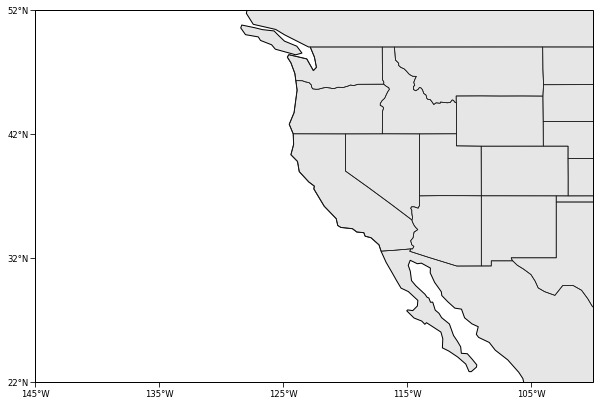

In [25]:
# Create figure
fig = plt.figure(figsize=(10,7)) 

# Add plot axes and draw basemap
ax = fig.add_subplot(111, projection=mapcrs)
ax.set_extent([lonmin,lonmax,latmin,latmax], crs=mapcrs)

# xticks
ax.set_xticks(dx, crs=mapcrs)      
lon_formatter = LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
# yticks
ax.set_yticks(dy, crs=mapcrs)
lat_formatter = LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
# tick params
ax.tick_params(direction='out', labelsize=8.5, length=5, pad=2, color='black')    

# Map features
ax.add_feature(cfeature.LAND, facecolor='0.9') 
ax.add_feature(cfeature.BORDERS, edgecolor='0.1', linewidth=0.7)
ax.add_feature(cfeature.COASTLINE, edgecolor='k', linewidth=1.0)
ax.add_feature(cfeature.STATES, edgecolor='0.1', linewidth=0.7)

# show basemap
plt.show()

# Geopotenital height lines
# clevs_hgts = np.arange(840,1280,12)
# cs = ax.contour(lons, lats, hgts/10., transform=datacrs,
#                 levels=clevs_hgts,
#                 colors='blue',         # line color
#                 linewidths=1.1)     # line thickness
#                 
# # Add labels to contour lines
# plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)

# # Show
# plt.show()  


In [26]:
def draw_basemap():

    # Create figure
    fig = plt.figure(figsize=(10,7)) 

    # Add plot axes and draw basemap
    ax = fig.add_subplot(111, projection=mapcrs)
    ax.set_extent([lonmin,lonmax,latmin,latmax], crs=mapcrs)

    # xticks
    ax.set_xticks(dx, crs=mapcrs)      
    lon_formatter = LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    # yticks
    ax.set_yticks(dy, crs=mapcrs)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    # tick params
    ax.tick_params(direction='out', labelsize=8.5, length=5, pad=2, color='black')    

    # Map features
    ax.add_feature(cfeature.LAND, facecolor='0.9') 
    ax.add_feature(cfeature.BORDERS, edgecolor='0.1', linewidth=0.7)
    ax.add_feature(cfeature.COASTLINE, edgecolor='k', linewidth=1.0)
    ax.add_feature(cfeature.STATES, edgecolor='0.1', linewidth=0.7)
    
    return fig, ax


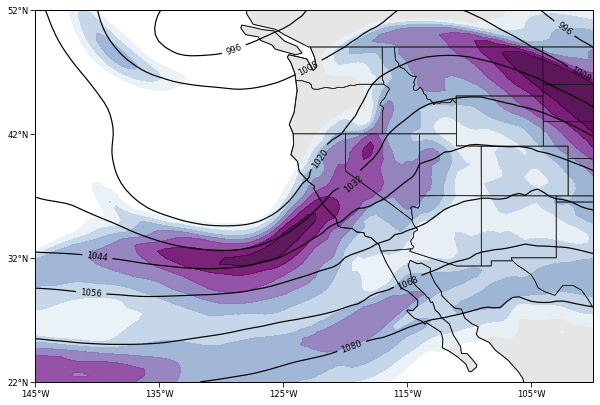

In [32]:
# Draw basemap
fig, ax = draw_basemap()

# Geopotenital height lines
clevs_hgts = np.arange(840,1280,12)
cs = ax.contour(lons, lats, hgts/10., transform=datacrs,
                levels=clevs_hgts,
                colors='k',         # line color
                linewidths=1.2)     # line thickness
               
# Add labels to contour lines
plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)

# Wind speed - contour fill
clevs_wspd = np.arange(60,121,10)
cf = ax.contourf(lons, lats, wspd_knots, transform=datacrs,
                 levels=clevs_wspd, 
                 cmap='BuPu', 
                 extend='max',
                 alpha=0.9)   # transparency (0=transparent, 1=opaque)

# show
plt.show()


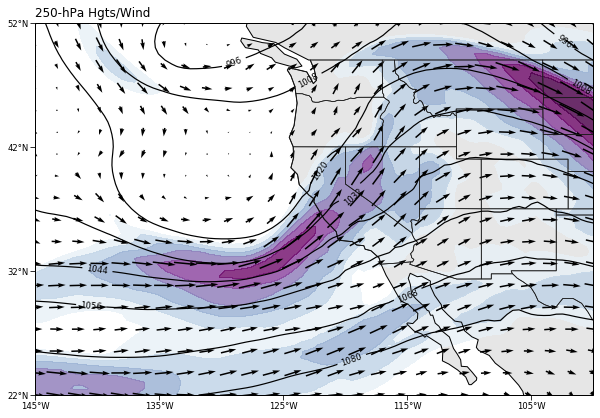

In [37]:
# Draw basemap
fig, ax = draw_basemap()

# Geopotenital height lines
clevs_hgts = np.arange(840,1280,12)
cs = ax.contour(lons, lats, hgts/10., transform=datacrs,
                levels=clevs_hgts,
                colors='k',         # line color
                linewidths=1.2)     # line thickness
               
# Add labels to contour lines
plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)

# Wind speed - contour fill
clevs_wspd = np.arange(70,131,10)
cf = ax.contourf(lons, lats, wspd_knots, transform=datacrs,
                 levels=clevs_wspd, 
                 cmap='BuPu', 
                 extend='max',
                 alpha=0.8)   # transparency (0=transparent, 1=opaque)

# Wind vectors 
ax.quiver(lons, lats, uwnd, vwnd, transform=datacrs, 
          color='k', regrid_shape=18, pivot='middle')

# Plot title
titlestring = f"{plev}-hPa Hgts/Wind"
ax.set_title(titlestring, loc='left',fontsize=12)

# show
plt.show()


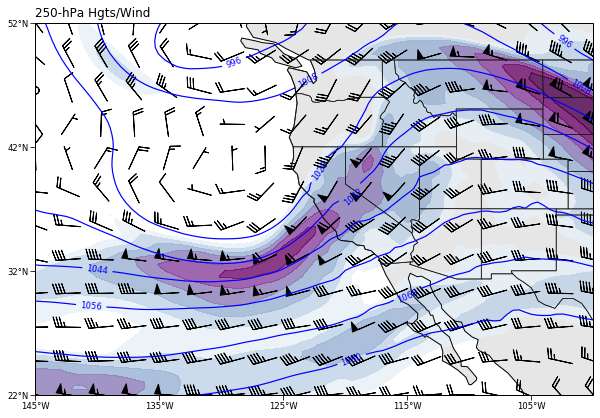

In [42]:
# Draw basemap
fig, ax = draw_basemap()

# Geopotenital height lines
clevs_hgts = np.arange(840,1280,12)
cs = ax.contour(lons, lats, hgts/10., transform=datacrs,
                levels=clevs_hgts,
                colors='b',         # line color
                linewidths=1.2)     # line thickness
               
# Add labels to contour lines
plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)

# Wind speed - contour fill
clevs_wspd = np.arange(70,131,10)
cf = ax.contourf(lons, lats, wspd_knots, transform=datacrs,
                 levels=clevs_wspd, 
                 cmap='BuPu', 
                 extend='max',
                 alpha=0.8)   # transparency (0=transparent, 1=opaque)

# Wind barbs
ax.barbs(lons, lats, uwnd, vwnd, transform=datacrs, 
          color='k', regrid_shape=12, pivot='middle')

# Plot title
titlestring = f"{plev}-hPa Hgts/Wind"
ax.set_title(titlestring, loc='left',fontsize=12)

# show
plt.show()
